# Kaggle Dogs vs. Cats Keras tutorial


This script goes along the blog post
"Building powerful image classification models using very little data"
from blog.keras.io.
It uses data that can be downloaded at:
https://www.kaggle.com/c/dogs-vs-cats/data
In our setup, we:
- created a data/ folder
- created train/ and validation/ subfolders inside data/
- created cats/ and dogs/ subfolders inside train/ and validation/
- put the cat pictures index 0-999 in data/train/cats
- put the cat pictures index 1000-1400 in data/validation/cats
- put the dogs pictures index 12500-13499 in data/train/dogs
- put the dog pictures index 13500-13900 in data/validation/dogs  

So that we have 1000 training examples for each class, and 400 validation examples for each class.
In summary, this is our directory structure:

In [1]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras import optimizers
import os
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# dimensions of our images.
img_width, img_height = 150, 150
top_model_weights_path = '..\\cats_dogs\\bottleneck_fc_model.h5'
#top_model_weights_path = 'fc_model.h5'
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 20
batch_size = 16
# path to the model weights files.
#weights_path = '../keras/examples/vgg16_weights.h5'

## Using the bottleneck features

In [3]:
def save_bottleneck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    #np.save(open('bottleneck_features_train.npy', 'w'), bottleneck_features_train)
    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples // batch_size)
    #np.save(open('bottleneck_features_validation.npy', 'w'), bottleneck_features_validation)
    np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [6]:
save_bottleneck_features()

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [23]:
def train_top_model():
    #train_data = np.load(open('bottleneck_features_train.npy'))
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array([0] * int(nb_train_samples / 2) + [1] * int(nb_train_samples / 2))

    #validation_data = np.load(open('bottleneck_features_validation.npy'))
    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([0] * int(nb_validation_samples / 2) + [1] * int(nb_validation_samples / 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='sgd',loss='binary_crossentropy', metrics=['accuracy']) # change for multi
    #model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy']) # change for multi

    history = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)
    
    plt.figure(1) 
    
    # summarize history for accuracy
    
    plt.subplot(211)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

Train on 2000 samples, validate on 800 samples
Epoch 1/20
2000/2000 [==============================] - 3s 2ms/step - loss: 0.6117 - acc: 0.6655 - val_loss: 0.5679 - val_acc: 0.6900

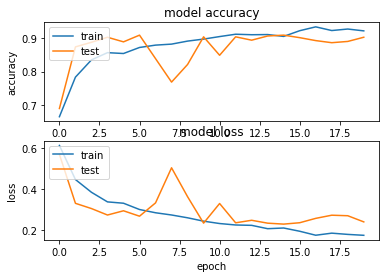

In [25]:
# train
train_top_model()

## Fine tuning

In [3]:
train_data_dir = '..\\cats_dogs\\data\\train'
validation_data_dir = '..\\cats_dogs\\data\\train'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 10
batch_size = 16

In [4]:
# build the VGG16 network
model = applications.VGG16(weights='imagenet', include_top=False, input_shape = (img_width, img_height, 3) )

In [5]:
# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)


In [6]:
# the model object above is not of type sequential, and does not have the .add method. We copy layers in model into new_model
new_model = Sequential()
for l in model.layers:
    new_model.add(l)

In [7]:
# add the model on top of the convolutional base
new_model.add(top_model)


# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in new_model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
new_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [8]:

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

# fine-tune the model
new_model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:29: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., epochs=10, validation_data=<keras.pre..., steps_per_epoch=125, validation_steps=800)`


Epoch 1/10
125/125 [==============================] - 2602s 21s/step - loss: 0.2294 - acc: 0.8955 - val_loss: 0.1110 - val_acc: 0.9638

In [9]:
# save the final fine tuned model
new_model.save('vgg_16_tuned.h5')

In [ ]:
# predictions on test data
#y_pred = new_model.predict()